In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from sktime.datasets import load_airline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.pipeline import make_pipeline

In [140]:
from google.colab import drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [141]:
import numpy as np

# Percorso del file numpy sul Google Drive
file_path = '/content/drive/My Drive/time_series/X_finale_normalizzato_100.npy'

# Carica il file numpy
ts_paa_vect_100 = np.load(file_path)

# Ora puoi utilizzare l'array come desideri
print(ts_paa_vect_100)


[[[-1.35342846 -0.54679428 -0.09868485 ... -0.60510409 -0.57368688
   -0.53019092]]

 [[ 1.82934715  1.44253884  1.22338628 ... -0.09593232 -0.08222257
   -0.04981418]]

 [[-0.19527997 -0.24787918 -0.24199419 ... -0.78402417 -0.7269895
   -0.57397279]]

 ...

 [[-2.05221771 -1.90669871 -1.78462348 ... -0.00631283 -0.0566858
   -0.10125349]]

 [[ 0.04729931  0.17150614  0.19923252 ... -0.19287054 -0.18494962
   -0.15545524]]

 [[-1.90984771 -1.35121918 -1.06456067 ... -0.01308497  0.02295059
    0.03761901]]]


In [142]:
import numpy as np

# Percorso del file numpy sul Google Drive
file_path = '/content/drive/My Drive/time_series/y_finale_normalizzato_100.npy'

# Carica il file numpy
y_sampled_100 = np.load(file_path)

# Ora puoi utilizzare l'array come desideri
print(y_sampled_100)


['opera' 'minimal-techno' 'goth' ... 'salsa' 'salsa' 'songwriter']


In [143]:
from sktime.classification.deep_learning import CNNClassifier


In [144]:
ts_paa_vect_100.shape

(2000, 1, 160)

In [145]:
y_sampled_100.shape

(2000,)

In [146]:
ts_paa_vect_100

array([[[-1.35342846, -0.54679428, -0.09868485, ..., -0.60510409,
         -0.57368688, -0.53019092]],

       [[ 1.82934715,  1.44253884,  1.22338628, ..., -0.09593232,
         -0.08222257, -0.04981418]],

       [[-0.19527997, -0.24787918, -0.24199419, ..., -0.78402417,
         -0.7269895 , -0.57397279]],

       ...,

       [[-2.05221771, -1.90669871, -1.78462348, ..., -0.00631283,
         -0.0566858 , -0.10125349]],

       [[ 0.04729931,  0.17150614,  0.19923252, ..., -0.19287054,
         -0.18494962, -0.15545524]],

       [[-1.90984771, -1.35121918, -1.06456067, ..., -0.01308497,
          0.02295059,  0.03761901]]])

In [147]:
y_sampled_100

array(['opera', 'minimal-techno', 'goth', ..., 'salsa', 'salsa',
       'songwriter'], dtype='<U17')

In [148]:
from sklearn.preprocessing import LabelEncoder

y = LabelEncoder().fit_transform(y_sampled_100)

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    ts_paa_vect_100, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 1, 160), (400, 1, 160), (1600,), (400,))

## CNN

In [150]:
from sktime.classification.deep_learning import CNNClassifier
import tensorflow as tf
from tensorflow import keras

In [151]:
cnn = CNNClassifier(
    n_epochs=10,
    batch_size=16,
    n_conv_layers=2,
    metrics=["accuracy"],
    random_state=42,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="loss")],
)

In [152]:
%%time
cnn.fit(X_train, y_train)
cnn.score(X_test, y_test)

25/25 [==============================] - 0s 3ms/step
CPU times: user 5.86 s, sys: 192 ms, total: 6.05 s
Wall time: 7.03 s


0.105

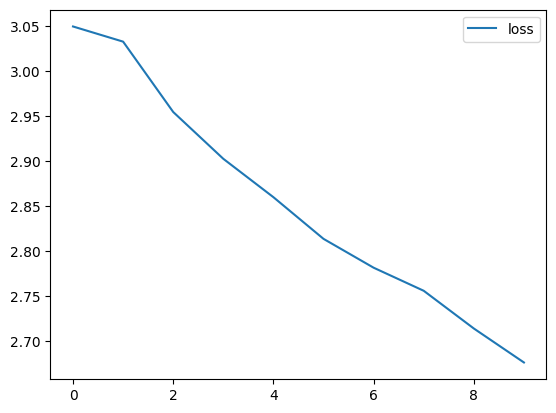

In [153]:
sns.lineplot(cnn.history.history["loss"], label="loss")
plt.show()

Keras

In [154]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D, LeakyReLU
from keras.layers import Activation, Conv1D, BatchNormalization
from keras.callbacks import EarlyStopping

In [155]:
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, Activation, Dropout, GlobalAveragePooling1D, Dense

def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()

    model.add(
        Conv1D(
            filters=16, kernel_size=8, activation="relu", input_shape=(n_timesteps, 1)
        )
    )
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=32, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(n_outputs, activation="softmax"))  # Cambiato da 'sigmoid' a 'softmax'
    model.compile(
        loss="sparse_categorical_crossentropy",  # Cambiato la funzione di perdita
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        metrics=["accuracy"],
    )

    return model


In [156]:
X_train.shape

(1600, 1, 160)

In [157]:
X_train_cnn = np.swapaxes(X_train, 1, 2)
X_test_cnn = np.swapaxes(X_test, 1, 2)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train)), 1
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  160
N. LABELS:  20


In [158]:
import numpy as np

# Supponiamo che il tuo array con le serie temporali sia chiamato X_train_cnn
# e hai eseguito lo swap degli assi

# Ottieni le dimensioni dell'array
n_samples, n_timesteps, n_features = X_train_cnn.shape

# Supponiamo che tu voglia esaminare la prima serie temporale
# Seleziona la prima serie temporale
first_time_series = X_train_cnn[0]

# Ottieni un istante temporale specifico (ad esempio, il primo)
# e controlla quanti valori ci sono in quell'istante temporale
first_time_step = first_time_series[0]
n_values_in_first_time_step = len(first_time_step)

print("Numero di caratteristiche in ogni istante temporale:", n_values_in_first_time_step)


Numero di caratteristiche in ogni istante temporale: 1


In [159]:
cnn = build_simple_cnn(n_timesteps, n_outputs)
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 153, 16)           144       
                                                                 
 batch_normalization_9 (Bat  (None, 153, 16)           64        
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 153, 16)           0         
                                                                 
 dropout_9 (Dropout)         (None, 153, 16)           0         
                                                                 
 conv1d_18 (Conv1D)          (None, 149, 32)           2592      
                                                                 
 batch_normalization_10 (Ba  (None, 149, 32)           128       
 tchNormalization)                                    

In [160]:
es = EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)
callbacks = [es]

In [161]:
%%time
cnn.fit(
    X_train_cnn,
    y_train,
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    validation_split=0.3,
)

Epoch 1/100
70/70 [==============================] - 3s 20ms/step - loss: 3.0018 - accuracy: 0.0455 - val_loss: 2.9958 - val_accuracy: 0.0625
Epoch 2/100
70/70 [==============================] - 2s 23ms/step - loss: 2.9725 - accuracy: 0.0554 - val_loss: 2.9956 - val_accuracy: 0.0521
Epoch 3/100
70/70 [==============================] - 2s 27ms/step - loss: 2.9442 - accuracy: 0.0741 - val_loss: 2.9946 - val_accuracy: 0.0437
Epoch 4/100
70/70 [==============================] - 2s 25ms/step - loss: 2.9329 - accuracy: 0.0777 - val_loss: 2.9909 - val_accuracy: 0.0521
Epoch 5/100
70/70 [==============================] - 1s 20ms/step - loss: 2.9264 - accuracy: 0.0777 - val_loss: 2.9826 - val_accuracy: 0.0812
Epoch 6/100
70/70 [==============================] - 1s 16ms/step - loss: 2.9174 - accuracy: 0.0723 - val_loss: 2.9719 - val_accuracy: 0.0667
Epoch 7/100
70/70 [==============================] - 1s 15ms/step - loss: 2.9020 - accuracy: 0.0821 - val_loss: 2.9622 - val_accuracy: 0.0562
Epoch 

In [162]:
cnn.history.history

{'loss': [3.0017807483673096,
  2.9725444316864014,
  2.9442033767700195,
  2.9329447746276855,
  2.9263598918914795,
  2.917393207550049,
  2.9019663333892822,
  2.9041574001312256,
  2.8949904441833496,
  2.8965930938720703,
  2.884931802749634,
  2.8904380798339844,
  2.869920015335083,
  2.880932569503784,
  2.871567964553833,
  2.8729021549224854,
  2.863380193710327,
  2.8596644401550293,
  2.8474862575531006,
  2.8524811267852783,
  2.8502345085144043,
  2.839324474334717,
  2.838477373123169,
  2.8308730125427246,
  2.8234736919403076,
  2.8199782371520996,
  2.8217580318450928,
  2.8069889545440674,
  2.8106772899627686,
  2.808931589126587,
  2.804018259048462,
  2.8045215606689453,
  2.7997305393218994,
  2.794473648071289,
  2.7933547496795654,
  2.786445140838623,
  2.7908387184143066,
  2.7954256534576416,
  2.778061628341675,
  2.7794432640075684,
  2.768428325653076,
  2.7844390869140625,
  2.7795403003692627,
  2.77297043800354,
  2.766608238220215,
  2.769724130630493

In [163]:
summary = pd.DataFrame(cnn.history.history)
summary

,loss,accuracy,val_loss,val_accuracy
0,3.001781,0.045536,2.995752,0.062500
1,2.972544,0.055357,2.995617,0.052083
2,2.944203,0.074107,2.994609,0.043750
3,2.932945,0.077679,2.990933,0.052083
4,2.926360,0.077679,2.982556,0.081250
...,...,...,...,...
95,2.667096,0.158036,2.760642,0.133333
96,2.653475,0.172321,2.755828,0.141667
97,2.650873,0.178571,2.752914,0.141667
98,2.637816,0.185714,2.752424,0.139583


In [164]:
summary

,loss,accuracy,val_loss,val_accuracy
0,3.001781,0.045536,2.995752,0.062500
1,2.972544,0.055357,2.995617,0.052083
2,2.944203,0.074107,2.994609,0.043750
3,2.932945,0.077679,2.990933,0.052083
4,2.926360,0.077679,2.982556,0.081250
...,...,...,...,...
95,2.667096,0.158036,2.760642,0.133333
96,2.653475,0.172321,2.755828,0.141667
97,2.650873,0.178571,2.752914,0.141667
98,2.637816,0.185714,2.752424,0.139583


In [165]:
summary.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

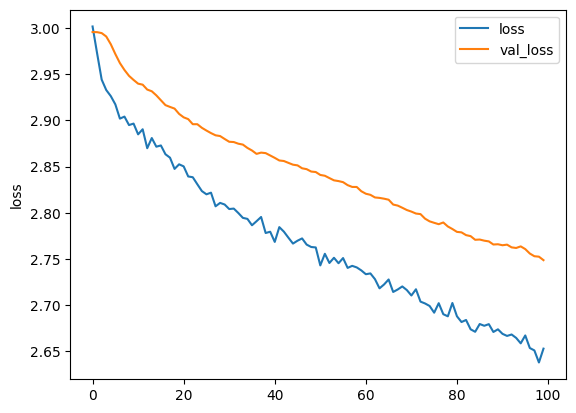

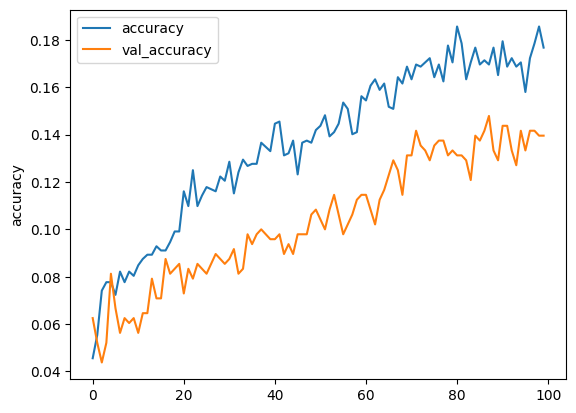

In [166]:
sns.lineplot(summary["loss"], label="loss")
sns.lineplot(summary["val_loss"], label="val_loss")
plt.show()

sns.lineplot(summary["accuracy"], label="accuracy")
sns.lineplot(summary["val_accuracy"], label="val_accuracy")
plt.show()

In [167]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)
print("Accuracy %s" % accuracy_score(y_test, y_pred))

13/13 [==============================] - 0s 9ms/step
Accuracy 0.14
